In [58]:
import pandas as pd 
import numpy as np 

In [59]:
df = pd.read_csv('data/CC GENERAL.csv')
df.isnull().sum().sum()

314

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [61]:
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())

In [62]:
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())
df['MINIMUM_PAYMENTS'].mean()

864.2065423050827

In [63]:
df = df.drop('CUST_ID', axis=1)

In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(df)
X_norm[0][0]

-0.7319893664465486

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns 

In [67]:
silhoette_res = {'cluster': [], 'silhoette': []}
def get_silhoette(num_cluster, X):
    model = KMeans(n_clusters = num_cluster, random_state=42)
    preds = model.fit_predict(X)
    silhoette = silhouette_score(X_norm, preds)
    return silhoette

In [68]:
for i in range(2, 10):
    silhoette_res['cluster'].append(i)
    silhoette_res['silhoette'].append(get_silhoette(i, X_norm))
    
print (silhoette_res)

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9], 'silhoette': [0.20950134853896507, 0.2505299806322502, 0.1976074492720698, 0.1931688590154638, 0.20259398485856092, 0.21436877398647777, 0.2185524558994579, 0.22605314920897515]}


<AxesSubplot:xlabel='cluster', ylabel='silhoette'>

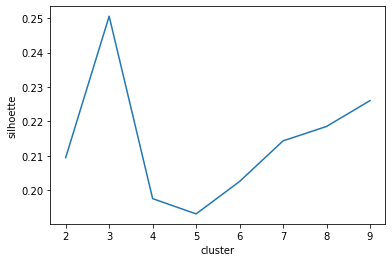

In [69]:
sns.lineplot(data=silhoette_res, x='cluster', y='silhoette')

In [71]:
k_means = KMeans(n_clusters=3, random_state=42)
preds = k_means.fit_predict(X_norm)
df.loc[:, 'label'] = k_means.labels_
df.label.value_counts()

0    6118
1    1597
2    1235
Name: label, dtype: int64

In [74]:
from sklearn.cluster import DBSCAN

In [86]:
dbscan = DBSCAN()
dbscan.fit(X_norm)
clusters = dbscan.labels_
len(set(clusters))- (1 if -1 in clusters else 0)

38

In [89]:
def get_silhoette_db(eps, min_samples, X):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    preds = model.fit_predict(X)
    silhoette = silhouette_score(X, preds)
    return silhoette

In [91]:
siliuette_list_dbscan = []
for i in np.arange(0.1, 3, 0.2):
    for j in range(1, 20, 4):
        siliuette_list_dbscan.append((i, j, get_silhoette_db(i, j, X_norm), len(set(dbscan.labels_))))

In [92]:
df_dbscan = pd.DataFrame(siliuette_list_dbscan, columns=['eps', 'min_samples', 'sil_score', 'number_of_clusters'])

In [93]:
df_dbscan.sort_values(by='sil_score')

,eps,min_samples,sil_score,number_of_clusters
11,0.5,5,-0.443701,39
16,0.7,5,-0.438837,39
6,0.3,5,-0.424475,39
7,0.3,9,-0.404209,39
30,1.3,1,-0.399305,39
...,...,...,...,...
74,2.9,17,0.591924,39
66,2.7,5,0.592182,39
73,2.9,13,0.595399,39
72,2.9,9,0.603811,39


In [94]:
from sklearn.cluster import AgglomerativeClustering

In [106]:
siliuette_list_hierarchical = []
 
for cluster in range(3,10,1):
        agglomerative = AgglomerativeClustering(affinity='euclidean',n_clusters=cluster).fit_predict(X_norm)
        sil_score = silhouette_score(X_norm, agglomerative, metric='euclidean')
        siliuette_list_hierarchical.append((cluster, sil_score,len(set(agglomerative)) ) )
        
df_hierarchical = pd.DataFrame(siliuette_list_hierarchical, columns=['cluster', 'sil_score','number_of_clusters'])
 
 
df_hierarchical.sort_values(by = 'sil_score')

,cluster,sil_score,number_of_clusters
5,8,0.152035,8
6,9,0.153719,9
1,4,0.154709,4
4,7,0.156415,7
2,5,0.158069,5
0,3,0.173110,3
3,6,0.173356,6


In [107]:
model = AgglomerativeClustering(affinity='euclidean', n_clusters=6).fit(X_norm)
df['cluster_id'] = model.labels_
df['cluster_id'].value_counts()

0    3946
1    2931
2     864
5     722
3     464
4      23
Name: cluster_id, dtype: int64

In [109]:
import plotly as plt